# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
# stdlib
import os
import shutil
import sqlite3

# 3rd party
import ipyparallel as ipp
import ipyvolume as ipv
import ipywidgets as ipw
import numpy as np
from scipy.optimize import minimize, curve_fit
import sympy as sp
import matplotlib.pyplot as plt

# local
import convergence as conv
import kelp_analyze
import kelp_compute
import mms
import discrete_plot
import run_utils as ru
#from fortran_wrappers.light_utils_wrap import light_utils_wrap as lu

In [177]:
from scipy.spatial import ConvexHull

In [353]:
def is_upper_bound(x_arr, y_arr, m, b):
    return np.all(y_arr<=m*x_arr+b)

def get_line(x1, x2, y1, y2):
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m*x1
    return m, b

def get_lines(x_arr, y_arr):
    """
    Return slope and intercept of all lines between adjacent points
    (and between last and first)
    """
    n = len(x_arr)
    lines = []
    for i in range(n):
        m, b = get_line(
            x_arr[i], 
            x_arr[(i+1)%n],
            y_arr[i], 
            y_arr[(i+1)%n],
        )
        lines.append([m, b])
        
    return lines

def exp_upper_bound(x_arr, y_arr):
    lx = np.log(x_arr)
    ly = np.log(y_arr)
    
    points = np.vstack([lx, ly]).T
    hull = ConvexHull(points)
    
    xv = lx[hull.vertices]
    yv = ly[hull.vertices]
    
    best_err = np.inf
    best_line = (0, 0)
    for i, (m, b) in enumerate(get_lines(xv, yv)):
        if is_upper_bound(xv, yv, m, b):
            err = np.sum(m*lx + b - ly)
            if err < best_err:
                best_line = (m, b)
                best_err = err
            
    return best_line

def robust_lin_regression(x_arr, y_arr, regressor=None):
    if regressor:
        reg = getattr(linear_model, regressor)()
    else:
        reg = linear_model.HuberRegressor()
    X = x_arr.reshape(-1, 1)
    y = y_arr
    reg.fit(X, y)
    vals = reg.predict([[0], [1]])
    b = vals[0]
    m = vals[1] - b
    
    return m, b
    
def robust_exp_regression(x_arr, y_arr, regressor=None):
    if regressor:
        reg = getattr(linear_model, regressor)
    else:
        reg = linear_model.HuberRegressor()
    reg.fit(np.log(x_arr).reshape(-1,1), np.log(y_arr))
    vals = reg.predict([[0], [1]])
    b = vals[0]
    m = vals[1] - b
    
    return m, b
    

## IPyParallel Setup

In [ ]:
#remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()
dv = ipc.direct_view()
print(ipc.ids)

In [ ]:
ipc.queue_status()

# Calculations

## 1D

### Compute

In [ ]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

nz_list = np.logspace(1, 2, 50, base=10).astype(int)
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 0
fd_flag = False
num_threads = 32

a_water = 0.01
b = 0
kelp_dist = 'top-heavy'

study_name = 'verify_kelp_th_bad_abspt_1d_noscat_nz_{}'.format(max(nz_list))
study_dir = os.path.join(base_dir, study_name)

ntheta = na
nphi = na

# TODO: Don't actually delete results

combine_thread, gs_fut = kelp_compute.verify_kelp_1d_compute_scalar_metrics(
    study_name, 
    a_water, b, nz_list, 
    kelp_dist, num_scatters, 
    fd_flag, lis_opts=None, num_threads=num_threads,
    base_dir=base_dir
)

### Plot

In [172]:
print(study_name)
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

verify_kelp_th_bad_abspt_1d_noscat_nz_100


In [ ]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

nz_list, = kelp_analyze.get_unique_vals(conn, study_name, ['nz'])

nz_arr = np.array(nz_list)

fig1 = plt.figure(1, figsize=[8,6])
fig2 = plt.figure(2, figsize=[8,6])
fig3 = plt.figure(3, figsize=[8,6])

pi_arr = np.zeros([len(nz_arr), 3])
flux_arr = np.zeros(len(nz_arr))


# For richardson extrapolation
dz_max1 = 5e-2

# For fitting errors
dz_max2 = 1e-1

for k, nz in enumerate(nz_arr):
    results_list = kelp_analyze.query_results(
        conn, study_name,
        nz=nz
    )

    flux = results_list[0]['flux'][:]
    pi_1 = results_list[0]['pi_1'][:]
    pi_3 = results_list[0]['pi_3'][:]
    pi_8 = results_list[0]['pi_8'][:]
    
    flux_arr[k] = flux
    pi_arr[k, :] = [pi_1, pi_3, pi_8]
    
dz_arr = 1/nz_arr

depths = [1, 3, 8]
inds1 = dz_arr<dz_max1
inds2 = dz_arr<dz_max2
for j, d in enumerate(depths):
    # Estimate true soln.
    plt.figure(1)
    #plt.plot(dz_arr, pi_arr[:,0], 'o-', label='z=1m')
    #plt.plot(dz_arr, pi_arr[:,1], 'o-', label='z=3m')
    plt.plot(dz_arr**2, pi_arr[:,j], 'o-', label='z={:d}m'.format(d))
    popt, pcov = curve_fit(lambda x, m, b: m*x+b, dz_arr[inds1]**2, pi_arr[inds1,j], p0=[0, 0])
    m, b = popt
    plt.plot(dz_arr**2, m*dz_arr**2+b, '--', label='fit z={:d}m'.format(d))
    print("b={:.2f}".format(b))
    best_err = np.abs(b-pi_arr[-1, j])
    best_rel = best_err / b
    print("best err = {:.2e}".format(best_err))
    print("best rel = {:.2e}".format(best_rel))
    
    abs_err_arr = np.abs(pi_arr[:,j] - b)
    rel_err_arr = np.abs(abs_err_arr/b)
    
    # Plot errors
    plt.figure(2)
    popt, pcov = curve_fit(lambda x, m, b: m*x+b, np.log(dz_arr[inds2]), np.log(abs_err_arr[inds2]), p0=[2, 0])
    m_err, b_err = popt
    plt.plot(dz_arr, abs_err_arr, 'C{}o-'.format(j), label='z={:d}m, m_err={:.2f}'.format(d, m_err))
    plt.plot(dz_arr, np.exp(b_err)*dz_arr**m_err, 'C{}--'.format(j))
    print("m_err(abs) = {:.2f}".format(m_err))
    
    # Plot errors
    plt.figure(3)
    popt, pcov = curve_fit(lambda x, m, b: m*x+b, np.log(dz_arr[inds2]), np.log(rel_err_arr[inds2]), p0=[2, 0])
    m_err, b_err = popt
    plt.plot(dz_arr, rel_err_arr, 'C{}o-'.format(j), label='z={:d}m, m_err={:.2f}'.format(d, m_err))
    plt.plot(dz_arr, np.exp(b_err)*dz_arr**m_err, 'C{}--'.format(j))
    print("m_err(rel) = {:.2f}".format(m_err))
    
plt.figure(1)
plt.title('')
plt.xlabel('dz^2')
plt.ylabel('PI')
plt.legend()

plt.figure(2)
plt.title('')
plt.legend()
plt.xlabel('dz')
plt.ylabel('abs err')
plt.xscale('log')
plt.yscale('log')

plt.figure(3)
plt.title('')
plt.legend()
plt.xlabel('dz')
plt.ylabel('rel err')
plt.xscale('log')
plt.yscale('log')

## 3D

### Compute

In [ ]:
base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
# base_dir = '/home/oliver/academic/research/kelp-results'

na = 8
ns_list = np.logspace(1, 2, 51, base=10).astype(int)

study_name = 'verify_kelp_th_bad_abspt_ss_a05_b03_scat1_test_{}x{}'.format(max(ns_list), na)
study_dir = os.path.join(base_dir, study_name)

ntheta = na
nphi = na

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 1
fd_flag = False

a_water = 0.5
b = 0
kelp_dist = 'top-heavy'

combine_thread, gs_fut = kelp_compute.verify_kelp_single_space_compute_scalar_metrics(
    study_name, 
    a_water, b, ns_list[::-1], na, 
    kelp_dist, num_scatters, 
    fd_flag, lis_opts=None, num_threads=None,
    base_dir=base_dir
)

### Plot

In [268]:
study_name = 'verify_kelp_th_bad_abspt_ss_sm_noscat_test_100x8'


flux
b=15924.50
best err = 6.60e+01
best rel = 4.14e-03
m_err(abs) = 2.02
m_err(rel) = 2.02

pi_1
b=10.86
best err = 7.37e-03
best rel = 6.79e-04
m_err(abs) = 2.17
m_err(rel) = 2.17

pi_3
b=0.40
best err = 1.69e-03
best rel = 4.26e-03
m_err(abs) = 2.27
m_err(rel) = 2.27

pi_8
b=0.00
best err = 1.60e-05
best rel = 1.15e-02
m_err(abs) = 1.54
m_err(rel) = 1.54


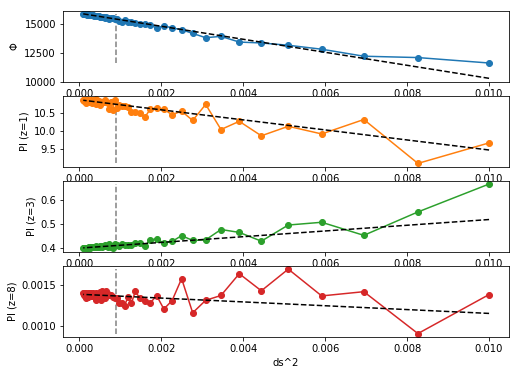

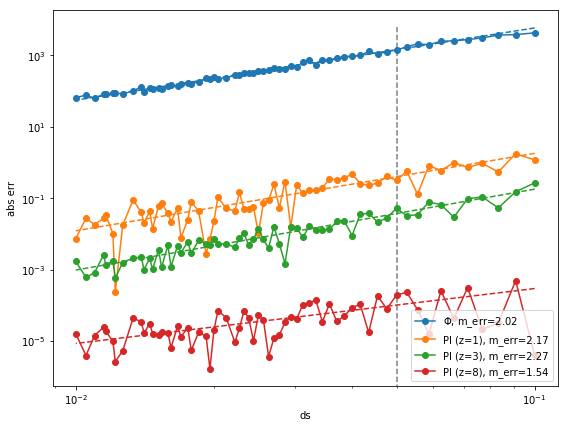

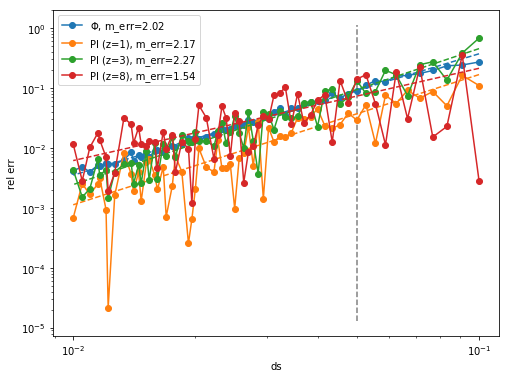

In [364]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

ns_list, = kelp_analyze.get_unique_vals(conn, study_name, ['ns'])
ns_arr = np.array(ns_list)

depths = [1, 3, 8]
scalar_metrics = [
    ('flux', r'$\Phi$'),
    *[
        ('pi_{}'.format(d), 'PI (z={})'.format(d))
        for d in depths
    ]
]

scalar_metric_array = np.zeros([
    len(ns_list),
    len(scalar_metrics)
])

for k, ns in enumerate(ns_arr):
    results_list = kelp_analyze.query_results(
        conn, study_name,
        ns=ns
    )
    scalar_metric_array[k,:] = [
       results_list[0][metric][:]
        for (metric, _) in scalar_metrics
    ]
    
fig1 = plt.figure(1, figsize=[8,6])
ax1_list = fig1.subplots(len(scalar_metrics))
fig2 = plt.figure(2, figsize=[8,6])
fig3 = plt.figure(3, figsize=[8,6])

pi_arr = np.zeros([len(ns_arr), 3])
flux_arr = np.zeros(len(ns_arr))

# For richardson extrapolation
ds_max1 = 3e-2

# For fitting errors
ds_max2 = 5e-2

ds_arr = 1/ns_arr
inds1 = ds_arr<=ds_max1
inds2 = ds_arr<=ds_max2

for j, (metric, metric_label) in enumerate(scalar_metrics):
    print()
    print(metric)
    # Estimate true soln.
    plt.figure(1)
    #plt.plot(ds_arr, pi_arr[:,0], 'o-', label='z=1m')
    #plt.plot(ds_arr, pi_arr[:,1], 'o-', label='z=3m')
    #popt, pcov = curve_fit(lambda x, m, b: m*x+b, ds_arr[inds1]**2, scalar_metric_array[inds1,j], p0=[0, 0])
    #m, b = popt
    m, b = robust_lin_regression(ds_arr[inds1]**2, scalar_metric_array[inds1,j], 'LinearRegression')
    ax1_list[j].vlines(ds_max1**2, min(scalar_metric_array[:,j]), max(scalar_metric_array[:,j]), colors='0.5', linestyles='--')
    ax1_list[j].plot(ds_arr**2, scalar_metric_array[:,j], 'C{}o-'.format(j))
    ax1_list[j].plot(ds_arr**2, m*ds_arr**2+b, 'k--'.format(j))
    
    ax1_list[j].set_title('')
    ax1_list[j].set_xlabel('ds^2')
    ax1_list[j].set_ylabel(metric_label)
    print("b={:.2f}".format(b))
    best_err = np.abs(b-scalar_metric_array[-1, j])
    best_rel = best_err / b
    print("best err = {:.2e}".format(best_err))
    print("best rel = {:.2e}".format(best_rel))
    
    abs_err_arr = np.abs(scalar_metric_array[:,j] - b)
    rel_err_arr = np.abs(abs_err_arr/b)
    
    # Plot errors
    plt.figure(2)
    #m_err, b_err = exp_upper_bound(ds_arr[inds2], abs_err_arr[inds2])
    m_err, b_err = robust_exp_regression(ds_arr[inds2], abs_err_arr[inds2])
    plt.plot(ds_arr, abs_err_arr, 'C{}o-'.format(j), label='{}, m_err={:.2f}'.format(metric_label, m_err))
    plt.plot(ds_arr, np.exp(b_err)*ds_arr**m_err, 'C{}--'.format(j))
    print("m_err(abs) = {:.2f}".format(m_err))
    
    # Plot errors
    plt.figure(3)
    #m_err, b_err = exp_upper_bound(ds_arr[inds2], rel_err_arr[inds2])
    m_err, b_err = robust_exp_regression(ds_arr[inds2], rel_err_arr[inds2])
    plt.plot(ds_arr, rel_err_arr, 'C{}o-'.format(j), label='{}, m_err={:.2f}'.format(metric_label, m_err))
    plt.plot(ds_arr, np.exp(b_err)*ds_arr**m_err, 'C{}--'.format(j))
    print("m_err(rel) = {:.2f}".format(m_err))
    
plt.figure(2)
plt.title('')
plt.legend()
plt.xlabel('ds')
plt.ylabel('abs err')
plt.vlines(ds_max2, *plt.ylim(), colors='0.5', linestyles='--')
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')

plt.figure(3)
plt.title('')
plt.legend()
plt.xlabel('ds')
plt.ylabel('rel err')
plt.xscale('log')
plt.yscale('log')
plt.vlines(ds_max2, *plt.ylim(), colors='0.5', linestyles='--')